In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from scipy.stats import pearsonr
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import LeakyReLU  # this is already covered by import
import random
import seaborn as sns
import sklearn

from tensorflow.python.ops.gen_sparse_ops import add_many_sparse_to_tensors_map

## Setup

In [2]:
leaky_relu = LeakyReLU(alpha=0.01)

class CONFIG:
    def __init__(self):
        CONFIG.layer_1 = 12
        CONFIG.activation_1 = leaky_relu
        CONFIG.dropout = random.uniform(0.01, 0.80)
        CONFIG.layer_2 = 10
        CONFIG.activation_2 = "relu"
        CONFIG.layer_3 = 7
        CONFIG.optimizer = "adam"
        CONFIG.loss = "mae"
        CONFIG.metric = "accuracy"
        CONFIG.epoch = 6
        CONFIG.batch_size = 32


config = CONFIG()


def get_normalization_layer(name, dataset):
    # Create a Normalization layer for our feature.
    normalizer = preprocessing.Normalization()

    # Prepare a Dataset that only yields our feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer


def df_to_dataset(dataframe_X, dataframe_y, shuffle=True, batch_size=32):
    dataframe = dataframe_X.copy()
    labels = dataframe_y
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds


def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.ylim([0, 1.5])
    plt.title("Training and validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Error [MAE]")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_1_var(x, y):
    plt.scatter(X_train['BPME_13'], y_train, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('BPME_13')
    plt.ylabel('FAXS')
    plt.legend()    
    
def reg_coef(x, y, label=None, color=None, **kwargs):
    ax = plt.gca()
    r, p = pearsonr(x, y)
    ax.annotate(
        "r = {:.2f}".format(r), xy=(0.5, 0.5), xycoords="axes fraction", ha="center"
    )
    ax.set_axis_off()
    
def plot_vars_time(y):
    plt.scatter(one_pulse["Time"],y)
    plt.xlabel('Time')
    plt.ylabel(str(y.name))
    
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

Import data

In [3]:

pulse_data = pd.read_csv("../JET_EFIT_magnetic/sampled_data.csv")
pulse_data = pulse_data.dropna(axis=0)

y = pulse_data["FAXS"]
X = pulse_data.drop(["FAXS", "FBND", "Time"], axis=1)



Some exploratory plots

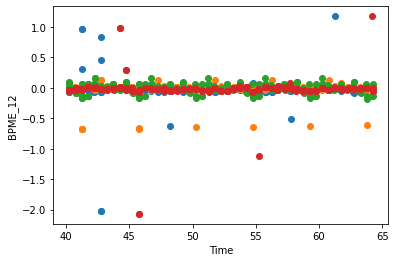

In [4]:
# plot FAXS, and some probes against time
#plot_vars_time(pulse_data["FAXS"])

# 190 to only look at one time slice
one_pulse = pulse_data[:190]

plot_vars_time(one_pulse["BPME_13"])
plot_vars_time(one_pulse["FLME_7"])
plot_vars_time(one_pulse["FLME_14"])
plot_vars_time(one_pulse["BPME_12"])


Check statistics

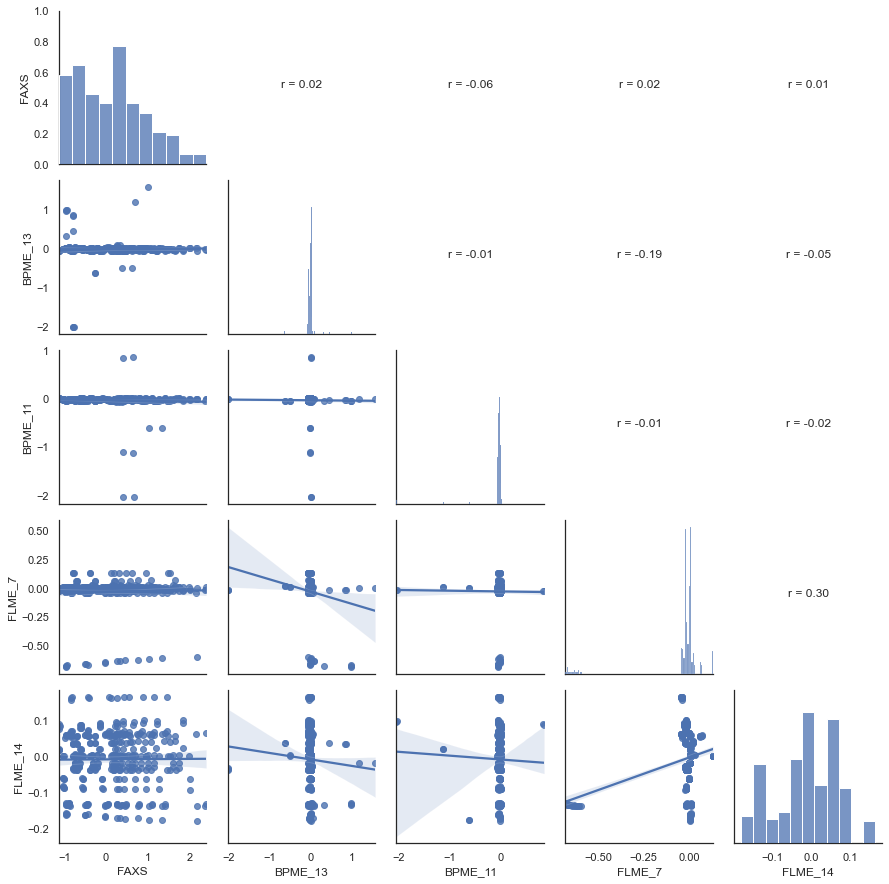

In [5]:
sns.set(style="white")

pair_plot = sns.PairGrid(pulse_data[['FAXS', 'BPME_13', 'BPME_11', 'FLME_7','FLME_14']])
pair_plot.map_diag(sns.histplot)
pair_plot.map_lower(sns.regplot)
pair_plot.map_upper(reg_coef)
plt.show()

# shall we exlcude all values close to zero? define some small range around 0 and try to ignore it?

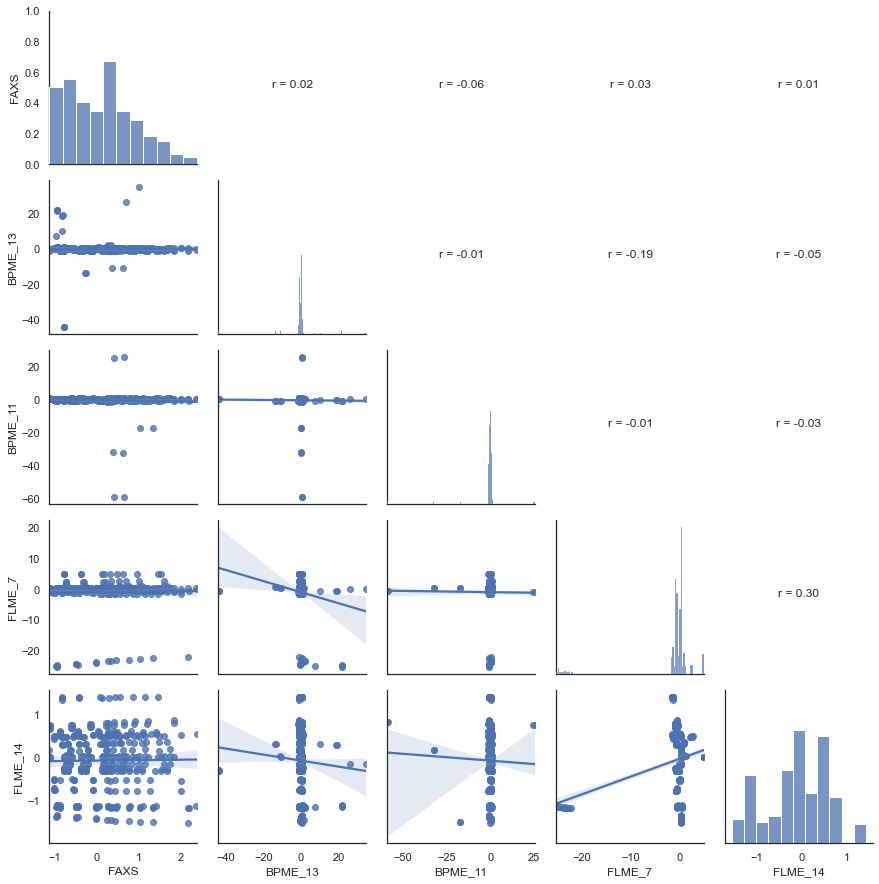

In [6]:
# try and fix distribution with scaling 
x_np = X.values #returns a numpy array
min_max_scaler = sklearn.preprocessing.RobustScaler()
x_scaled = min_max_scaler.fit_transform(x_np)
processed_df = pd.DataFrame(x_scaled, columns=X.columns)

#print(processed_df.shape)
#print(processed_df.head())
#print(y.shape)
#print(y.head())

result = pd.concat([processed_df,y],axis=1,join='inner')

#print(result.shape)
#print(result.head())

# found a mismatch in X and y indexing here? wonder if it explains the poor correlation

pair_plot2 = sns.PairGrid(result[['FAXS','BPME_13', 'BPME_11', 'FLME_7','FLME_14']])
pair_plot2.map_diag(sns.histplot)
pair_plot2.map_lower(sns.regplot)
pair_plot2.map_upper(reg_coef)
plt.show()

In [7]:
print(pulse_data.describe().transpose()[['mean', 'std']])


              mean       std
FAXS      0.120420  0.822241
FBND      0.885580  0.914039
Time     52.410838  8.295095
BPME_13  -0.022851  0.245345
BPME_17  -0.042618  0.205164
FLME_19  -0.042366  0.117462
BPME_9   -0.014746  0.195419
FLME_17   0.008846  0.094223
BPME_15  -0.035088  0.171885
BPME_6    0.028976  0.403662
FLME_14  -0.008491  0.080167
BPME_1   -0.000458  0.012762
FLME_12  -0.028657  0.166699
BPME_4    0.002834  0.131903
BPME_18  -0.040777  0.129938
BPME_7    0.004489  0.088617
FLME_13  -0.025188  0.086453
BPME_3   -0.001670  0.035347
FLME_9   -0.055496  0.193025
FLME_10  -0.017101  0.053852
FLME_38   0.026728  0.274919
BPME_11  -0.032423  0.186289
FLME_8   -0.007432  0.024769
FLME_20   0.024980  0.110418
FLME_11   0.000630  0.060033
FLME_18  -0.024818  0.129153
FLME_16  -0.028436  0.093404
BPME_5   -0.001269  0.016878
BPME_0   -0.000052  0.000416
BPME_12  -0.024841  0.246943
BPME_16  -0.046941  0.190630
FLME_7   -0.026231  0.135816
BPME_8    0.001054  0.136794
FLME_15  -0.01

## Preprocessing

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=24
)

# doing val split inside fit for time being
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=24
)


print(len(X_train), "train examples")
print(len(X_val), "validation examples")
print(len(X_test), "test examples")

print(type(X_train))
print(type(X))

print(X_train.describe().transpose()[['mean', 'std']])


236 train examples
60 validation examples
74 test examples
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
             mean       std
BPME_13 -0.025093  0.262644
BPME_17 -0.049616  0.228944
FLME_19 -0.046424  0.118706
BPME_9  -0.024260  0.229347
FLME_17  0.006926  0.092070
BPME_15 -0.045869  0.166465
BPME_6   0.020864  0.357395
FLME_14 -0.008120  0.079468
BPME_1  -0.000734  0.010042
FLME_12 -0.028860  0.163478
BPME_4   0.008301  0.159686
BPME_18 -0.043399  0.149357
BPME_7   0.007439  0.092452
FLME_13 -0.019919  0.086224
BPME_3  -0.000501  0.028762
FLME_9  -0.063998  0.199741
FLME_10 -0.016106  0.053617
FLME_38  0.017232  0.271997
BPME_11 -0.044247  0.225500
FLME_8  -0.008135  0.025003
FLME_20  0.023486  0.113627
FLME_11 -0.000674  0.061553
FLME_18 -0.017184  0.126390
FLME_16 -0.024307  0.096293
BPME_5  -0.000351  0.019276
BPME_0  -0.000056  0.000427
BPME_12 -0.012679  0.213829
BPME_16 -0.054119  0.215216
FLME_7  -0.022734  0.130048
BPME_8   0.001445  0.1295

Preprocessing- normalisation

In [9]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))
print(normalizer.mean.numpy())


first = np.array(X_train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())


[-2.5093343e-02 -4.9615569e-02 -4.6424255e-02 -2.4259649e-02
  6.9255829e-03 -4.5868944e-02  2.0864043e-02 -8.1199585e-03
 -7.3375169e-04 -2.8859854e-02  8.3007645e-03 -4.3399323e-02
  7.4391742e-03 -1.9918691e-02 -5.0057663e-04 -6.3997917e-02
 -1.6106095e-02  1.7231643e-02 -4.4246729e-02 -8.1350822e-03
  2.3486076e-02 -6.7413069e-04 -1.7184081e-02 -2.4307076e-02
 -3.5079548e-04 -5.6020926e-05 -1.2678855e-02 -5.4118615e-02
 -2.2734459e-02  1.4446205e-03 -1.2250117e-02 -3.2669835e-02
 -1.2740844e-03 -1.6417623e-02 -2.3757488e-02]
First example: [[-0.52 -0.03  0.21  0.   -0.07 -0.   -0.01  0.   -0.   -0.51 -0.   -0.07
   0.02  0.06  0.    0.03 -0.07 -0.05 -0.05  0.03 -0.16 -0.02 -0.03 -0.09
  -0.   -0.   -0.02 -0.03  0.01  0.01  0.02 -0.   -0.    0.   -0.02]]

Normalized: [[-1.88  0.09  2.2   0.11 -0.82  0.27 -0.08  0.13  0.05 -2.94 -0.05 -0.17
   0.16  0.9   0.02  0.45 -1.07 -0.26 -0.03  1.44 -1.61 -0.4  -0.09 -0.71
  -0.18  0.07 -0.01  0.12  0.24  0.07  0.25  0.13  0.05  0.1   0.01]]


### One variable linear model
Linear regression test (one variable: BPME_13 )

In [10]:
BPME_13  = np.array(X_train['BPME_13'])

BPME_13_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
BPME_13_normalizer.adapt(BPME_13)


one_var_model = tf.keras.Sequential([
    BPME_13_normalizer,
    layers.Dense(units=1)
])

one_var_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Test one var model dims

In [11]:
print('one var predictions',one_var_model.predict(BPME_13[:10]))
""" just checking has correct dim 10x1, output expected to be bad"""
#print('actual',y_train[:10])

one_var_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


one var predictions [[ 2.3338366 ]
 [-4.196016  ]
 [ 0.08983035]
 [-0.03553481]
 [ 0.16111979]
 [ 0.07975151]
 [-0.20592332]
 [ 0.09666529]
 [ 0.06987561]
 [ 0.1270573 ]]


Train one var model, linear regression

In [90]:
history_1v = one_var_model.fit(
    X_train['BPME_13'], y_train,
    epochs=100,
    # can suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_data=(X_val['BPME_13'], y_val))


Test results of one var model

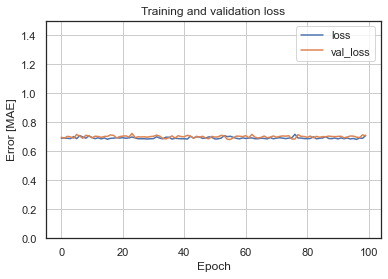

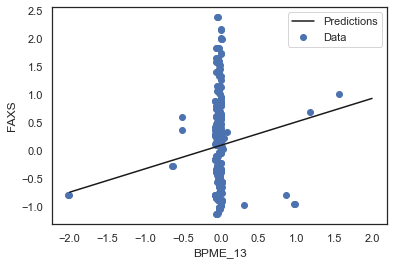

In [91]:
hist = pd.DataFrame(history_1v.history)
hist['epoch'] = history_1v.epoch
hist.tail()
plot_loss(history_1v)

onevar_x = tf.linspace(-2, 2, 20)
onevar_y = one_var_model.predict(onevar_x)

plot_1_var(onevar_x,onevar_y)


Results=very bad! are these things even correlated...


Though shows promise- should we exclude all the zero data?


Or persuade the network to weight the input less when value is near zero

### All inputs linear model

In [84]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [88]:
history = linear_model.fit(
    X_train, y_train, 
    epochs=100,
    # suppress logging
    verbose=0,
    validation_data=(X_val, y_val))


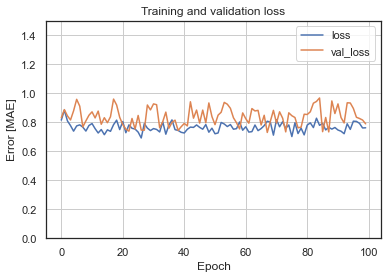

In [89]:
plot_loss(history)




Performance got worse(!)

## Shallow NN one input

In [95]:
dnn_oneinput_model = build_and_compile_model(BPME_13_normalizer)
dnn_oneinput_model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [96]:
%%time
history = dnn_oneinput_model.fit(
    X_train['BPME_13'], y_train,
    epochs=100,
    # can suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_data=(X_val['BPME_13'], y_val))


Wall time: 2.72 s


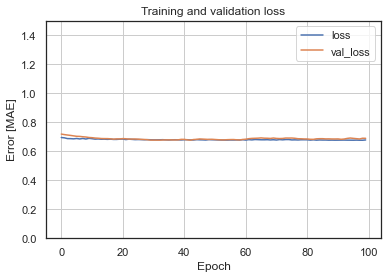

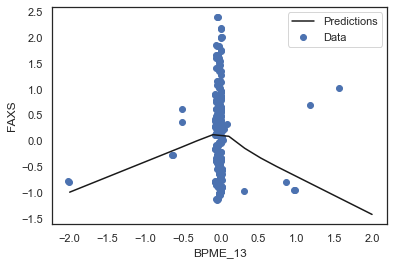

In [98]:
plot_loss(history)

#onevar_x = tf.linspace(-2, 2, 20)
# already declared above
onevar_dnn_y = dnn_oneinput_model.predict(onevar_x)

plot_1_var(onevar_x,onevar_dnn_y)


If anything performs worse than the one var linear model(!!)

Shallow NN all inputs

In [99]:
"""shallow_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(40, input_dim=35),
        tf.keras.layers.Dense(20, activation="relu"),
        tf.keras.layers.Dense(10),
    ]
)
"""

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 35)                71        
_________________________________________________________________
dense_11 (Dense)             (None, 64)                2304      
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 6,600
Trainable params: 6,529
Non-trainable params: 71
_________________________________________________________________


In [100]:
history = dnn_model.fit(
    X_train, y_train,
    epochs=100,
    # can suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_data=(X_val, y_val))


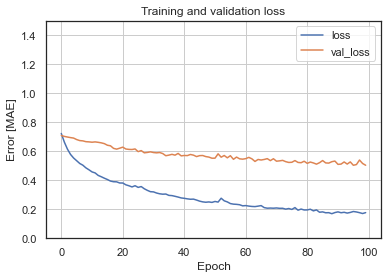

In [101]:
plot_loss(history)


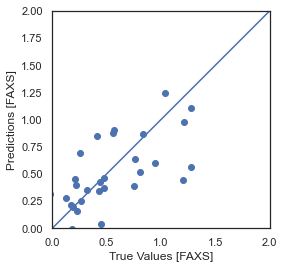

In [105]:
y_pred = dnn_model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values [FAXS]')
plt.ylabel('Predictions [FAXS]')
lims = [0, 2]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


Looks like we are overfitting, try shallower model with a dropout?

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 35)                71        
_________________________________________________________________
dense_23 (Dense)             (None, 40)                1440      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 20)                820       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 21        
Total params: 2,352
Trainable params: 2,281
Non-trainable params: 71
_________________________________________________________________
None


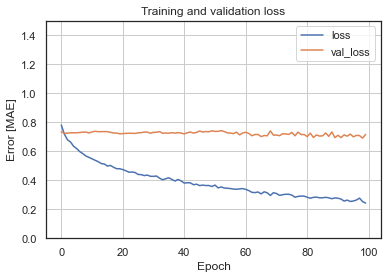

In [111]:

model = keras.Sequential(
    [   normalizer,
        layers.Dense(40, activation="relu"),
        layers.Dropout(0.01),
        layers.Dense(20, activation="relu"),
        layers.Dense(1),
    ]
)

model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))
    


print(model.summary())
history = model.fit(
    X_train, y_train,
    epochs=100,
    # can suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_data=(X_val, y_val))

plot_loss(history)


In [16]:
num_epochs = 100
# Not worried about memory or local minima
batchSize = len(X_train)

# Train on data
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=batchSize,
    epochs=num_epochs,
)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.7063 - mae: 0.7063 - val_loss: 0.7196 - val_mae: 0.7196
Epoch 2/100
1/1 [==============================] - 0s 35ms/step - loss: 0.7046 - mae: 0.7046 - val_loss: 0.7186 - val_mae: 0.7186
Epoch 3/100
1/1 [==============================] - 0s 36ms/step - loss: 0.7030 - mae: 0.7030 - val_loss: 0.7176 - val_mae: 0.7176
Epoch 4/100
1/1 [==============================] - 0s 43ms/step - loss: 0.7013 - mae: 0.7013 - val_loss: 0.7166 - val_mae: 0.7166
Epoch 5/100
1/1 [==============================] - 0s 36ms/step - loss: 0.6998 - mae: 0.6998 - val_loss: 0.7158 - val_mae: 0.7158
Epoch 6/100
1/1 [==============================] - 0s 38ms/step - loss: 0.6983 - mae: 0.6983 - val_loss: 0.7149 - val_mae: 0.7149
Epoch 7/100
1/1 [==============================] - 0s 37ms/step - loss: 0.6969 - mae: 0.6969 - val_loss: 0.7141 - val_mae: 0.7141
Epoch 8/100
1/1 [==============================] - 0s 42ms/step - loss: 0.6955 - mae: 0.6955